In [10]:
import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords

from string import punctuation

import pymorphy2

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def creat_df():
    data_list = []
    with open("dataset.txt", encoding = 'utf-8') as file:
        for line in file:
            labels = line.split()[0]
            text = line[len(labels)+1:].strip()
            labels = labels.split(",")
            mask = [1 if "__label__NORMAL" in labels else 0,
                    1 if "__label__INSULT" in labels else 0,
                    1 if "__label__THREAT" in labels else 0,
                    1 if "__label__OBSCENITY" in labels else 0]
            data_list.append((text, *mask))
    return pd.DataFrame(data_list, columns=["comment", "normal", "insult", "threat", "obscenity"])

In [12]:
df = creat_df()
df

,comment,normal,insult,threat,obscenity
0,,0,0,0,0
1,муж наверное дома кушать готовит,0,0,0,0
2,за что 3млн?,0,0,0,0
3,класс! девочки молодцы! гордиться вами нужно!!!,0,0,0,0
4,автор поста явно не русский!!!?,0,0,0,0
...,...,...,...,...,...
248286,"это евгений леонов,а алексей леонов -космонавт.",0,0,0,0
248287,правильно всё по пять (5)...,0,0,0,0
248288,а у меня наверное рекорд в 1962 году в училище...,0,0,0,0
248289,спасибо всем большое),0,0,0,0


In [9]:
# df = pd.read_csv('dataset_lemma_sw_preproc.csv')
# df['comment'] = df['comment'].astype(str)
# df = df.drop('Unnamed: 0', axis=1)
# df

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_lemma_sw_preproc.csv'

### Splitting into training and test datasets

In [13]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [14]:
print("Training data shape: ", df_train.shape)
print("Testing data shape: ",df_test.shape)

Training data shape:  (198632, 5)
Testing data shape:  (49659, 5)


### Clean Text

In [19]:
def preprocess_text(text):
    text = text.replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()
    text = "".join(text)
    return text.strip()

In [20]:
df_train['comment'] = df_train['comment'].apply(preprocess_text).apply(lambda x: preprocess_text(x))
df_test['comment'] = df_test['comment'].apply(preprocess_text).apply(lambda x: preprocess_text(x))

<ipython-input-20-edcdcf4df8f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comment'] = df_train['comment'].apply(preprocess_text).apply(lambda x: preprocess_text(x))
<ipython-input-20-edcdcf4df8f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['comment'] = df_test['comment'].apply(preprocess_text).apply(lambda x: preprocess_text(x))


In [21]:
df_train['comment']

90777     сэм вот что у тебя с еблом вдули так что перек...
44573                                там всю жизнь так было
73160                   дочка делает всегда быстро и вкусно
211473                не понимаю что за хрень морские тигры
1979                                   спокойной ночи и вам
                                ...                        
138075    просто ппц эта тыква себя в зеркало видит хоть...
4036      я такого выкармливала купить можно специальную...
190636            я бы такому пидару член ко рту подставить
8528      цена вопроса от стакана до поллитры никогда ещ...
179050    не самоловы а селки в списке пойманых добавте ...
Name: comment, Length: 198632, dtype: object

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


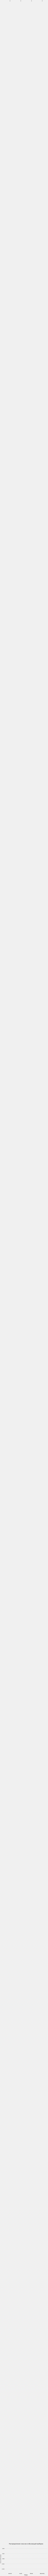

In [22]:
plt.style.use('fivethirtyeight')

colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = df_train.iloc[:,1:].sum()

plt.figure(figsize=(10,7))

ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Распределение классов в обучающей выборке")
plt.xlabel('Класс')
plt.ylabel('Кол-во комментариев', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

<ipython-input-23-9103cc476347>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


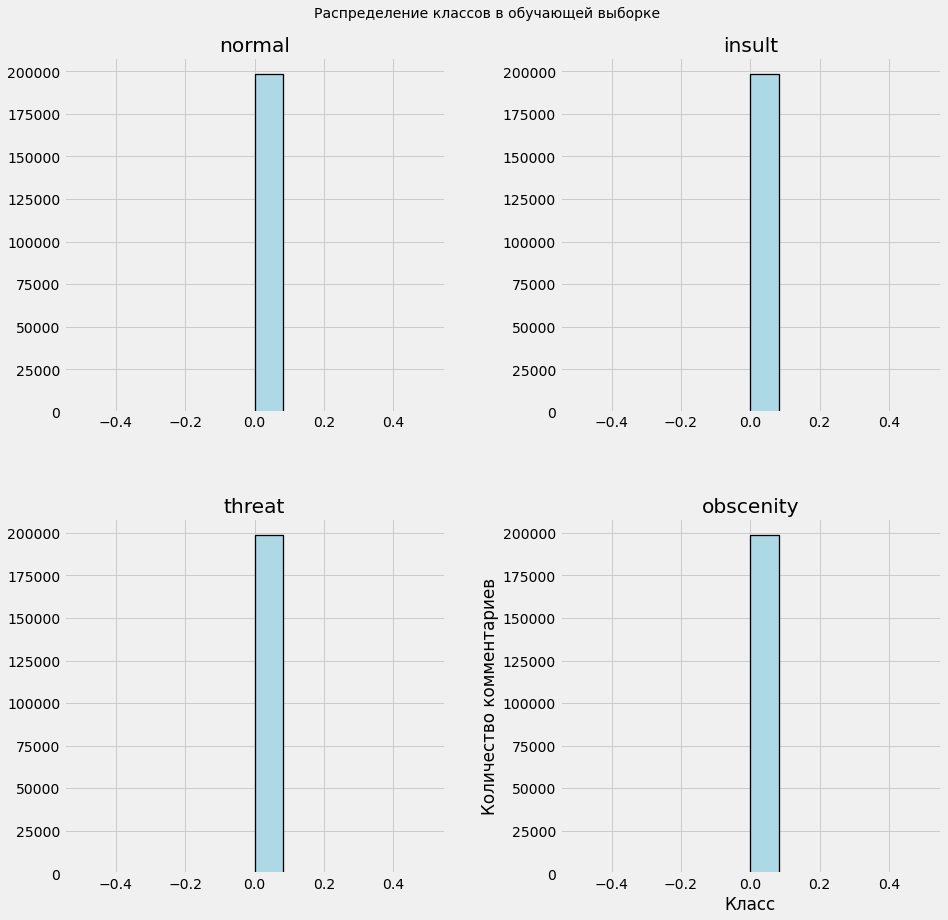

In [23]:
# plot distribution of training labels
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
df_train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Распределение классов в обучающей выборке',y = 0.93,size = 14)
plt.xlabel("Класс")
plt.ylabel("Количество комментариев")
plt.show()

> * Можно заметить, что существует высокий дисбаланс между классами.
> * Большенство значений равно нулю для всех классов, кроме класса "normal", унего ситуация обратная.

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


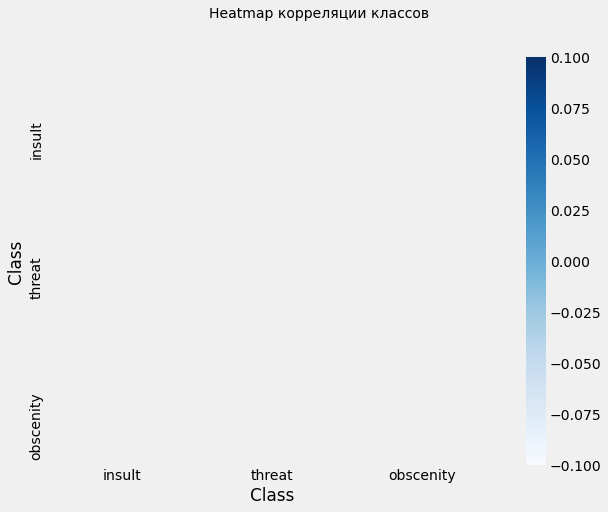

In [24]:
# heatmap for training data
fig = plt.figure(figsize = (9,7))
sns.heatmap(df_train.drop('normal', axis = 1).corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap корреляции классов',size = 14)
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

> * Корреляция классов очень низкая, например:
>   * threat и insult = 0.25;
>   * threat и obscenity = 0.0077;
>   * insult и obscenity = 0.11;
> * Это значит что если в сообщении есть угроза, то в нём присутствует             оскорбления с вероятностью 25%, а если сообщение непристойное, то с             вероятностью 0,007 в нем содержится угроза.

> Для устранения дисбаланса следует выполнить некоторую недостаточную или избыточную дискретизацию

### Under Sampling

* SMOTE(Метод синтетической передискретизации меньшинства), RandomOverSampler и RandomUnderSampler являются эффективными методами для выполнения передискретизации или недискретизации, но они плохо работают, когда в наборе данных существует огромный дисбаланс и очень мало выборок для определенного класса. Таким образом, эти методы не очень хорошо вписываются в этот набор данных.
* Отбросим 35% нетоксичных комментариев.
* Число 35% выбрано, чтобы не уменьшать набор данных на большую величину и все еще иметь достаточно комментариев, которые не являются токсичными для эффективного обучения модели.

In [25]:
# сохраним в переменную индексы нетоксических сообщений
normal_class = df_train[df_train['normal'] > 0].index
normal_class

Int64Index([], dtype='int64')

In [26]:
# вычислим 30% сообщений из выборки
part30percent = (len(normal_class)*30)/100
part30percent

0.0

In [27]:
# из найденных индексов выберем первые 35%
drop_part_normal_class = normal_class[ : round(part30percent)]
drop_part_normal_class

Int64Index([], dtype='int64')

In [28]:
drop_part_normal_class.shape

(0,)

In [29]:
# Удаляем первые 57069 (35%) строк из класса normal (не токсические сообщения)
df_train = df_train.drop(drop_part_normal_class, axis=0)

In [30]:
df_train.shape

(198632, 5)

In [31]:
df_train

,comment,normal,insult,threat,obscenity
90777,сэм вот что у тебя с еблом вдули так что перек...,0,0,0,0
44573,там всю жизнь так было,0,0,0,0
73160,дочка делает всегда быстро и вкусно,0,0,0,0
211473,не понимаю что за хрень морские тигры,0,0,0,0
1979,спокойной ночи и вам,0,0,0,0
...,...,...,...,...,...
138075,просто ппц эта тыква себя в зеркало видит хоть...,0,0,0,0
4036,я такого выкармливала купить можно специальную...,0,0,0,0
190636,я бы такому пидару член ко рту подставить,0,0,0,0
8528,цена вопроса от стакана до поллитры никогда ещ...,0,0,0,0


In [32]:
# определим тренировочные и тестовые признаки
feature_train = df_train['comment'].values
feature_test = df_test['comment'].values

# определим тренировочные и тестовые классы
target_train = df_train.drop('comment', axis = 1).values
target_test = df_test.drop('comment', axis = 1).values

In [33]:
print("feature_train:\n", feature_train[:3], 
      "\n\n\nfeature_test:\n", feature_test[:3], 
      "\n\n\ntarget_train:\n", target_train[:3], 
      "\n\n\ntarget_test:\n", target_test[:3], sep='')

feature_train:
['сэм вот что у тебя с еблом вдули так что перекосило'
 'там всю жизнь так было' 'дочка делает всегда быстро и вкусно']


feature_test:
['тут родственники не хотят общаться что говорить о соседях'
 'а этого пидора кто опять выпустил'
 'это конечно печально но у вас должен быть договор и чеки об оплате обратитесь в полицию']


target_train:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


target_test:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


### Data Processing

#### Tokenize and pad the text data

In [34]:
max_features = 30000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(feature_train)+list(feature_test))

token_feature_train = tokenizer.texts_to_sequences(feature_train)
token_feature_test = tokenizer.texts_to_sequences(feature_test)

feature_train = sequence.pad_sequences(token_feature_train, maxlen=maxlen)
feature_test = sequence.pad_sequences(token_feature_test, maxlen=maxlen)

#### Embeddings

In [39]:
EMBEDDING_FILE = 'cc.ru.300.vec'
embed_size = 300

In [40]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [41]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [42]:
#plot accuracy and loss curves
def plot_history(history):
    
    plt.figure(figsize=(8,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['accuracy'])
    
    plt.plot(np.arange(0,n)+1,history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_accuracy'],'r')  
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show()

In [43]:
# функция для оценки модели на валидационной выборке
def model_evalulate(model_name):
    
    testres = model_name.evaluate(feature_test, target_test, verbose=0)
    
    print("Validation set")
    print('loss:', testres[0])
    print("accuracy:" ,testres[1])

### Data Modelling

In [47]:
def model_grn():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(4, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    return model

In [48]:
# функция для компиляции и подгонки модели
def model_run(X, y, batch_size, n_epochs):
    
    # call model_cnn to compile the model
    model = model_grn()
    
    # fit the model
    history = model.fit(X, y,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_split=0.1)
    
    return (history, model)

In [49]:
batch_size = 32
n_epochs = 4

In [50]:
history_1, model_1 = model_run(feature_train, target_train, batch_size, n_epochs)

Epoch 1/4
4211/4211 [==============================] - 2801s 665ms/step - loss: 0.1044 - accuracy: 0.9273 - auc: 0.9897 - recall: 0.9223 - precision: 0.9395 - val_loss: 0.0622 - val_accuracy: 0.9568 - val_auc: 0.9958 - val_recall: 0.9549 - val_precision: 0.9644
Epoch 2/4
4211/4211 [==============================] - 3866s 918ms/step - loss: 0.0623 - accuracy: 0.9505 - auc: 0.9959 - recall: 0.9558 - precision: 0.9635 - val_loss: 0.0644 - val_accuracy: 0.9514 - val_auc: 0.9952 - val_recall: 0.9541 - val_precision: 0.9642
Epoch 3/4
4211/4211 [==============================] - 3047s 724ms/step - loss: 0.0427 - accuracy: 0.9602 - auc: 0.9978 - recall: 0.9700 - precision: 0.9751 - val_loss: 0.0784 - val_accuracy: 0.9478 - val_auc: 0.9925 - val_recall: 0.9490 - val_precision: 0.9562
Epoch 4/4
4211/4211 [==============================] - 3003s 713ms/step - loss: 0.0291 - accuracy: 0.9667 - auc: 0.9988 - recall: 0.9800 - precision: 0.9840 - val_loss: 0.0948 - val_accuracy: 0.9426 - val_auc: 0.99

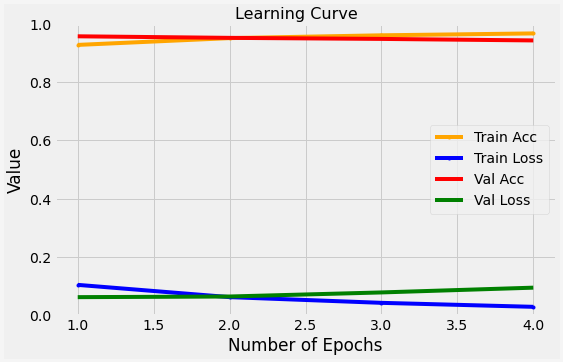

In [51]:
plot_history(history_1)

In [52]:
model_evalulate(model_1)

Validation set
loss: 0.10024529695510864
accuracy: 0.941801905632019


### Optimisation

> * Воспользуемся поиском по сетке для оптимизации.
> * Поскольку поиск по сетке занимает довольно много времени, будем брать первые 30 000 признаков обучающих данных, .

#### Grid Search for batch size and epoch

> * Размер партии от 32 до 100 выбирается для определения оптимального размера.
> * Используются эпохи от 3 до 6.
> * Реализована перекрестная проверка 3

In [114]:
%%time
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn = model_grn, verbose=1)

batch_size = [32,40,50]
epochs = [3,4,5]

param_grid = dict(batch_size = batch_size, 
                  epochs = epochs)

#Grid search for best parameter
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)

grid_result = grid.fit(feature_train[:3000], target_train[:3000])

Epoch 1/3
63/63 [==============================] - 30s 478ms/step - loss: 0.3864 - accuracy: 0.8030 - auc: 0.8794 - recall_145: 0.6905 - precision_145: 0.8046
Epoch 2/3
63/63 [==============================] - 31s 488ms/step - loss: 0.2901 - accuracy: 0.8355 - auc: 0.9360 - recall_145: 0.7365 - precision_145: 0.8305
Epoch 3/3
32/32 [==============================] - 4s 127ms/step - loss: 0.2051 - accuracy: 0.8490 - auc: 0.9678 - recall_145: 0.8228 - precision_145: 0.8840
Epoch 1/3
63/63 [==============================] - 29s 455ms/step - loss: 0.3906 - accuracy: 0.8160 - auc: 0.8765 - recall_146: 0.7014 - precision_146: 0.7715
Epoch 2/3
63/63 [==============================] - 28s 437ms/step - loss: 0.2930 - accuracy: 0.8360 - auc: 0.9342 - recall_146: 0.7389 - precision_146: 0.8335
Epoch 3/3
32/32 [==============================] - 4s 134ms/step - loss: 0.1931 - accuracy: 0.8540 - auc: 0.9721 - recall_146: 0.8596 - precision_146: 0.8954
Epoch 1/3
63/63 [==============================]

20/20 [==============================] - 4s 201ms/step - loss: 0.2355 - accuracy: 0.8490 - auc: 0.9598 - recall_165: 0.8055 - precision_165: 0.8705
Epoch 1/4
40/40 [==============================] - 23s 575ms/step - loss: 0.4188 - accuracy: 0.8160 - auc: 0.8651 - recall_166: 0.7044 - precision_166: 0.7924
Epoch 2/4
40/40 [==============================] - 23s 580ms/step - loss: 0.3069 - accuracy: 0.8310 - auc: 0.9289 - recall_166: 0.7035 - precision_166: 0.8305
Epoch 3/4
40/40 [==============================] - 26s 639ms/step - loss: 0.2436 - accuracy: 0.8545 - auc: 0.9570 - recall_166: 0.8243 - precision_166: 0.8569
Epoch 4/4
20/20 [==============================] - 4s 193ms/step - loss: 0.2076 - accuracy: 0.8490 - auc: 0.9669 - recall_166: 0.8278 - precision_166: 0.8814
Epoch 1/4
40/40 [==============================] - 25s 625ms/step - loss: 0.4166 - accuracy: 0.7935 - auc: 0.8653 - recall_167: 0.6665 - precision_167: 0.8029
Epoch 2/4
40/40 [==============================] - 25s 633

In [121]:
# распечатать результат поиска по сетке
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

top_batch_size = grid_result.best_params_.get('batch_size') #32
top_epochs = grid_result.best_params_.get('epochs') #4

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.868000 by using {'batch_size': 32, 'epochs': 5}

0.851667 (0.002055) using {'batch_size': 32, 'epochs': 3}
0.863667 (0.020726) using {'batch_size': 32, 'epochs': 4}
0.868000 (0.009626) using {'batch_size': 32, 'epochs': 5}
0.854667 (0.013888) using {'batch_size': 40, 'epochs': 3}
0.863667 (0.020758) using {'batch_size': 40, 'epochs': 4}
0.849333 (0.020806) using {'batch_size': 40, 'epochs': 5}
0.845333 (0.015326) using {'batch_size': 50, 'epochs': 3}
0.857333 (0.020072) using {'batch_size': 50, 'epochs': 4}
0.865000 (0.015122) using {'batch_size': 50, 'epochs': 5}


>* Лучшие значения с точностью 86,8% и потерями 0,007:
>  * batch 32,
>  * epoch 4,

In [102]:
def model_grid(optimizer='adam'):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(4, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

top_dropout_rate = grid_result.best_params_.get('dropout_rate')

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

In [111]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn = model_grid, epochs = top_epochs, batch_size = top_batch_size, verbose=1)

optimizer = ['SGD', 'Adam', 'Adamax']

param_grid = dict(optimizer=optimizer)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)

grid_result = grid.fit(feature_train[:3000], target_train[:3000])

Epoch 1/4
75/75 [==============================] - 29s 386ms/step - loss: 0.6033 - accuracy: 0.7783 - auc: 0.8462 - recall_128: 0.6440 - precision_128: 0.7820
Epoch 2/4
75/75 [==============================] - 28s 373ms/step - loss: 0.4937 - accuracy: 0.8275 - auc: 0.8868 - recall_128: 0.6993 - precision_128: 0.8275
Epoch 3/4
75/75 [==============================] - 28s 379ms/step - loss: 0.4294 - accuracy: 0.8275 - auc: 0.8937 - recall_128: 0.6993 - precision_128: 0.8275
Epoch 4/4
19/19 [==============================] - 2s 127ms/step - loss: 0.3846 - accuracy: 0.8267 - auc: 0.8989 - recall_128: 0.6957 - precision_128: 0.8267
Epoch 1/4
75/75 [==============================] - 27s 361ms/step - loss: 0.6320 - accuracy: 0.7113 - auc: 0.8221 - recall_129: 0.6805 - precision_129: 0.6294
Epoch 2/4
75/75 [==============================] - 27s 361ms/step - loss: 0.5274 - accuracy: 0.8321 - auc: 0.8813 - recall_129: 0.7012 - precision_129: 0.8321
Epoch 3/4
75/75 [==============================

In [122]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

top_optimizer = grid_result.best_params_.get('optimizer')

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.868000 by using {'batch_size': 32, 'epochs': 5}

0.851667 (0.002055) using {'batch_size': 32, 'epochs': 3}
0.863667 (0.020726) using {'batch_size': 32, 'epochs': 4}
0.868000 (0.009626) using {'batch_size': 32, 'epochs': 5}
0.854667 (0.013888) using {'batch_size': 40, 'epochs': 3}
0.863667 (0.020758) using {'batch_size': 40, 'epochs': 4}
0.849333 (0.020806) using {'batch_size': 40, 'epochs': 5}
0.845333 (0.015326) using {'batch_size': 50, 'epochs': 3}
0.857333 (0.020072) using {'batch_size': 50, 'epochs': 4}
0.865000 (0.015122) using {'batch_size': 50, 'epochs': 5}


Модель имеет наивысшую точность и наименьшую погрешность с оптимизатором Adam.

### LEARNINIG RATE

I will check the models performance with learning rates between 0.0001 and 0.1

In [123]:
top_optimizer = tf.keras.optimizers.Adam
def model_learning_rate(learn_rate=0.01):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(4, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                         optimizer = top_optimizer(learn_rate),
                         metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

In [126]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=model_learning_rate, epochs = top_epochs, batch_size = top_batch_size, verbose=1)

learn_rate = [0.0001,0.001,0.01,0.1]
param_grid = dict(learn_rate=learn_rate)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid,  cv = 5)

grid_result = grid.fit(feature_train[:3000], target_train[:3000])

Epoch 1/5
75/75 [==============================] - 44s 586ms/step - loss: 0.6204 - accuracy: 0.6808 - auc: 0.8052 - recall_174: 0.6204 - precision_174: 0.6377
Epoch 2/5
75/75 [==============================] - 49s 660ms/step - loss: 0.4270 - accuracy: 0.8275 - auc: 0.8599 - recall_174: 0.6993 - precision_174: 0.8275
Epoch 3/5
75/75 [==============================] - 55s 738ms/step - loss: 0.3365 - accuracy: 0.8275 - auc: 0.9121 - recall_174: 0.6993 - precision_174: 0.8275
Epoch 4/5
75/75 [==============================] - 56s 740ms/step - loss: 0.3287 - accuracy: 0.8275 - auc: 0.9157 - recall_174: 0.6993 - precision_174: 0.8275
Epoch 5/5
19/19 [==============================] - 4s 195ms/step - loss: 0.3265 - accuracy: 0.8267 - auc: 0.9210 - recall_174: 0.6957 - precision_174: 0.8267
Epoch 1/5
75/75 [==============================] - 52s 698ms/step - loss: 0.5948 - accuracy: 0.7475 - auc: 0.8485 - recall_175: 0.5846 - precision_175: 0.7895
Epoch 2/5
75/75 [==============================

75/75 [==============================] - 58s 769ms/step - loss: 0.5289 - accuracy: 0.7796 - auc: 0.9001 - recall_191: 0.7412 - precision_191: 0.7613
Epoch 3/5
75/75 [==============================] - 58s 770ms/step - loss: 0.4118 - accuracy: 0.8104 - auc: 0.9230 - recall_191: 0.7609 - precision_191: 0.7886
Epoch 4/5
75/75 [==============================] - 58s 771ms/step - loss: 0.4049 - accuracy: 0.8163 - auc: 0.9259 - recall_191: 0.7834 - precision_191: 0.7983
Epoch 5/5
19/19 [==============================] - 4s 209ms/step - loss: 0.5770 - accuracy: 0.8300 - auc: 0.9075 - recall_191: 0.7602 - precision_191: 0.8216
Epoch 1/5
75/75 [==============================] - 52s 695ms/step - loss: 0.5822 - accuracy: 0.7708 - auc: 0.8779 - recall_192: 0.6989 - precision_192: 0.7117
Epoch 2/5
75/75 [==============================] - 54s 717ms/step - loss: 0.4782 - accuracy: 0.7892 - auc: 0.9079 - recall_192: 0.7540 - precision_192: 0.7670
Epoch 3/5
75/75 [==============================] - 56s 74

In [127]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

top_learning_rate = grid_result.best_params_.get('learn_rate')

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.868667 by using {'learn_rate': 0.001}

0.827333 (0.013233) using {'learn_rate': 0.0001}
0.868667 (0.018209) using {'learn_rate': 0.001}
0.866667 (0.013864) using {'learn_rate': 0.01}
0.789000 (0.048963) using {'learn_rate': 0.1}


>* Скорость обучения 0,1 показывает наивысшую точность, но не самую низкую ошибку.
> * Выбор такой высокой скорости обучения приведет к очень быстрому обучению модели на данных и вызовет переобучение или недообучение.
> * Я выберу оптимальную скорость обучения 0,02, что дает второй лучший результат.

### Dropout rate

Исследуем производительность модели с dropout_rate от 0 до 0,4

In [133]:
def model_dropout_rate(dropout_rate=0.0):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(dropout_rate)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(4, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                         optimizer = top_optimizer(lr=top_learning_rate),
                         metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

In [ ]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn = model_dropout_rate, epochs = top_epochs, batch_size = top_batch_size, verbose=0)

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4] 

param_grid = dict(dropout_rate=dropout_rate)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs =1)

grid_result = grid.fit(feature_train[:30000], target_train[:30000])

In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

top_dropout_rate = grid_result.best_params_.get('dropout_rate')

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

> Лучшее качество модели при использовать dropout_rate 0,3.

### FINAL MODEL

In [44]:
# best parametr
top_batch_size = 256
top_epochs = 4
# top_optimizer = Adam
top_learning_rate = 0.01
top_dropout_rate = 0.4

In [45]:
def model_final( learning_rate, dropout_rate):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(top_dropout_rate)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(4, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

In [46]:
def model_run(X, y, batch_size, n_epochs, learning_rate, dropout_rate):
    
    model = model_final( learning_rate, dropout_rate)
    history = model.fit(X, y,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_split=0.1)
    
    return (history, model)


In [47]:
history_2, model_2 = model_run(feature_train[:3000], target_train[:3000], top_batch_size, top_epochs, top_learning_rate, top_dropout_rate)

Epoch 1/4
11/11 [==============================] - 24s 2s/step - loss: 0.3879 - accuracy: 0.7785 - auc: 0.8817 - recall: 0.7204 - precision: 0.7238 - val_loss: 0.2925 - val_accuracy: 0.8433 - val_auc: 0.9338 - val_recall: 0.7170 - val_precision: 0.8502
Epoch 2/4
11/11 [==============================] - 24s 2s/step - loss: 0.1874 - accuracy: 0.8759 - auc: 0.9741 - recall: 0.8275 - precision: 0.9158 - val_loss: 0.2337 - val_accuracy: 0.8233 - val_auc: 0.9615 - val_recall: 0.8434 - val_precision: 0.8575
Epoch 3/4
11/11 [==============================] - 26s 2s/step - loss: 0.0771 - accuracy: 0.9007 - auc: 0.9954 - recall: 0.9418 - precision: 0.9691 - val_loss: 0.2499 - val_accuracy: 0.8333 - val_auc: 0.9664 - val_recall: 0.8324 - val_precision: 0.8584
Epoch 4/4
11/11 [==============================] - 27s 2s/step - loss: 0.0323 - accuracy: 0.9033 - auc: 0.9987 - recall: 0.9840 - precision: 0.9877 - val_loss: 0.3015 - val_accuracy: 0.8567 - val_auc: 0.9579 - val_recall: 0.8324 - val_precis

In [153]:
model_evalulate(model_2)

Validation set
loss: 0.0866597443819046
accuracy: 0.9468363523483276


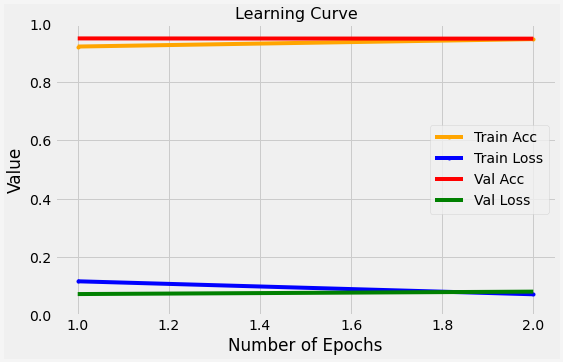

In [154]:
plot_history(history_2)

In [48]:
y_pred = model_2.predict(feature_test, verbose = 1, batch_size = 32)

1552/1552 [==============================] - 113s 73ms/step


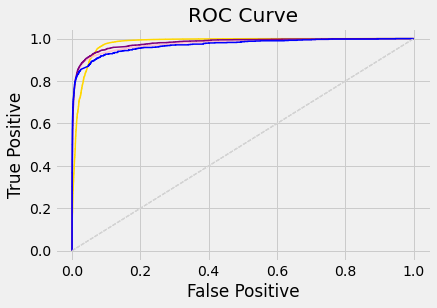

In [156]:
# график ROC AUC
from sklearn.metrics import roc_curve, auc

def plot_roc(y, y_pred, colors):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    plt.plot(fpr, tpr, color=colors, lw = 1.5, label='ROC AUC')
    plt.plot([0, 1], [0, 1], color='lightgrey', lw = 1, linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve')
plot_roc(target_test[:, 0], y_pred[:, 0],'gold')
plot_roc(target_test[:, 1], y_pred[:, 1],"pink")
plot_roc(target_test[:, 2], y_pred[:, 2],"purple")
plot_roc(target_test[:, 3], y_pred[:, 3],"b")

In [171]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def cm_for_each_label(Y, Y_pred,threshold,ClassName):

    Y_cls = Y
    Y_pred_cls = (Y_pred > threshold).astype(float)
    
    accuracy = accuracy_score(Y_cls, Y_pred_cls) 
    print("Accuracy Score: {}\n".format(accuracy))
 
#     print("Confusion Matrix:")
#     cm = confusion_matrix(Y_cls, Y_pred_cls)
#     print(cm)

#     ax= plt.subplot()
#     sns.heatmap(cm, annot=True, ax = ax,cmap='Blues')
   
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.suptitle(ClassName)
    print()
    print("Classification Report")
    print(classification_report(Y_cls, Y_pred_cls, target_names=["TRUE","FALSE"]))

In [173]:
for i in range(4):
    print(cm_for_each_label(target_test[:, i], y_pred[:, i], 0.5, "Class: Toxic"))

Accuracy Score: 0.9627854524950663


Classification Report
              precision    recall  f1-score   support

        TRUE       0.90      0.90      0.90      9004
       FALSE       0.98      0.98      0.98     40654

    accuracy                           0.96     49658
   macro avg       0.94      0.94      0.94     49658
weighted avg       0.96      0.96      0.96     49658

None
Accuracy Score: 0.9581134963147931


Classification Report
              precision    recall  f1-score   support

        TRUE       0.98      0.97      0.98     42208
       FALSE       0.85      0.87      0.86      7450

    accuracy                           0.96     49658
   macro avg       0.91      0.92      0.92     49658
weighted avg       0.96      0.96      0.96     49658

None
Accuracy Score: 0.9807684562406863


Classification Report
              precision    recall  f1-score   support

        TRUE       0.99      0.99      0.99     47223
       FALSE       0.80      0.81      0.81      2

In [84]:
texts = ['у тебя кожа как у старушки']

max_features = 30000
maxlen = 100

token_texts = tokenizer.texts_to_sequences(texts)
texts_seq = sequence.pad_sequences(token_texts, maxlen=maxlen)

y_pred_pred = model_2.predict(texts_seq, verbose = 1, batch_size = 2)

for i in y_pred_pred:
    print(texts[0],'\n')
    print("normal", "insult", "threat", "obscenity")
    for j in i:
        print('{:.4f}'.format(j), end=' ')
    print('\n')

1/1 [==============================] - 0s 2ms/step
отсоси 

normal insult threat obscenity
0.0003 0.3323 0.0015 0.9860 

